# Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing

# Import Data(.csv)

In [2]:
data = pd.read_csv('MLCoursework.csv') 
print(data.shape)
data.head()

(1606, 20)


,id,success,tokenNum,teamSize,country,categories,overallrating,offered_ownership,enddate,startdate,tokenName,tokenPrice,tokenType,platform,acceptingCurrency,softcap,hardcap,whitepaper,video,socialMedia
0,1,0,1.275000e+07,14,Estonia,"Charity,Education,Health,Smart Contract",2.6,0.80,15-04-2018,01-03-2018,REDLcoin,1 REDL = 1 USD,ERC20,Ethereum,ETH,1.0,1.0,1.0,1.0,0.0
1,2,0,0.000000e+00,13,Singapore,Infrastructure,2.1,0.70,25-08-2017,25-07-2017,SLOGN,1 SLOGN= 0.0001 ETH,"8,00,00,00,000",NaN,ETH,1.0,1.0,1.0,1.0,0.0
2,3,1,2.220000e+09,9,Singapore,"Platform,Business services",2.5,0.37,23-11-2017,18-11-2017,TNB,1 TNB = 0.00005 ETH,ERC20,Ethereum,NaN,1.0,1.0,1.0,0.0,3.0
3,4,0,4.000000e+07,0,USA,"Cryptocurrency,Business services,Entertainment...",1.5,0.80,26-04-2018,26-03-2018,GIF,1GIF = 0.00969635 USD,ERC20,Ethereum,"ETH, BTC, LTC",1.0,1.0,1.0,1.0,0.0
4,5,1,4.500000e+07,7,Mexico,"Internet,Infrastructure,Cryptocurrency,Busines...",2.1,0.50,18-05-2018,22-04-2018,AIRE,1 ETH = 4440 AIRE,ERC20,Ethereum,"ETH , BTC",1.0,1.0,1.0,0.0,0.0


# Describing Data

In [3]:
# datatype of each column
data.dtypes

id                     int64
success                int64
tokenNum             float64
teamSize               int64
country               object
categories            object
overallrating        float64
offered_ownership    float64
enddate               object
startdate             object
tokenName             object
tokenPrice            object
tokenType             object
platform              object
acceptingCurrency     object
softcap              float64
hardcap              float64
whitepaper           float64
video                float64
socialMedia          float64
dtype: object

In [4]:
# Numeric Data Columns
data_num = data._get_numeric_data().columns
print(data_num)

Index(['id', 'success', 'tokenNum', 'teamSize', 'overallrating',
       'offered_ownership', 'softcap', 'hardcap', 'whitepaper', 'video',
       'socialMedia'],
      dtype='object')


In [5]:
# Number of rows with values out of prescribed range
rg = ['softcap', 'hardcap', 'whitepaper', 'video', 'socialMedia']
for col in rg:
    print((data[col]).value_counts())

0.0    891
1.0    686
Name: softcap, dtype: int64
1.0    1091
0.0     486
Name: hardcap, dtype: int64
1.0    1500
0.0      77
Name: whitepaper, dtype: int64
1.0    1061
0.0     516
Name: video, dtype: int64
0.0    1167
3.0     232
2.0     129
1.0      49
Name: socialMedia, dtype: int64


In [6]:
# range (1,5)
print(((data['overallrating']<1) | (data['overallrating']>5)).value_counts())

False    1604
True        2
Name: overallrating, dtype: int64


In [7]:
# removing rows out of range
d1 = data[((data['overallrating']<1) | (data['overallrating']>5))]
print(d1.shape)
data = data.append(d1).drop_duplicates(subset='id',keep=False)
print(data.shape)

(2, 20)
(1604, 20)


In [8]:
# remove startdate with null value
data.dropna(subset = ["startdate"], inplace=True)

In [9]:
data.isna().sum()

id                     0
success                0
tokenNum             246
teamSize               0
country                0
categories             0
overallrating          0
offered_ownership    538
enddate                0
startdate              0
tokenName             31
tokenPrice           178
tokenType            455
platform             128
acceptingCurrency    225
softcap               29
hardcap               29
whitepaper            29
video                 29
socialMedia           29
dtype: int64

# Handling Missing values

In [10]:
# Handling missing values with mode
for column in ['softcap', 'hardcap', 'whitepaper', 'video', 'socialMedia', 'platform', 'acceptingCurrency','tokenType' ]:
    data[column].fillna(data[column].mode()[0], inplace=True)

In [11]:
#Imputing KNN imputer
for i in ['offered_ownership','tokenNum']:
    X1 = np.array(data[i]).reshape(-1,1)
    X2 = np.array(data.index).reshape(-1,1)
    X = np.hstack((X1,X2))
    from sklearn.impute import KNNImputer
    preprocessor = KNNImputer(n_neighbors=5, weights="distance")
    preprocessor.fit(X)
    X_prep = preprocessor.transform(X)
    data[i] = np.hsplit(X_prep, 2)[0].reshape(1,-1)[0]

In [12]:
data.isna().sum()

id                     0
success                0
tokenNum               0
teamSize               0
country                0
categories             0
overallrating          0
offered_ownership      0
enddate                0
startdate              0
tokenName             31
tokenPrice           178
tokenType              0
platform               0
acceptingCurrency      0
softcap                0
hardcap                0
whitepaper             0
video                  0
socialMedia            0
dtype: int64

# Handling Token Price column

In [13]:
# spliting the column with delimiter '='
data['cnt_TP'] = data['tokenPrice'].str.split('=', expand = True)[0]
data['ETH_TP'] = data['tokenPrice'].str.split('=', expand = True)[1]

In [14]:
country_Price = list(data['cnt_TP'])
ETH_price = list(data['ETH_TP'])

In [15]:
CTP = []
TP = []
for i in range(len(country_Price)):
    if 'ETH' in str(country_Price[i]):
        CTP.append(ETH_price[i])
        TP.append(country_Price[i])
    elif 'USD' in str(country_Price[i]):
        CTP.append(ETH_price[i])
        TP.append(country_Price[i])
    else:
        TP.append(ETH_price[i])
        CTP.append(country_Price[i])

data.cnt_TP=CTP
data.ETH_TP=TP

In [16]:
## initializing a new string to apppend only alphabets
alpha=[]
nums=[]


## looping through the string to find out alphabets
for i in TP:
    only_alpha = ""
    only_num = ""
    for char in str(i):
        if (ord(char) >= 65 and ord(char) <= 90) | (ord(char) >= 97 and ord(char) <= 122):
            only_alpha += char
        elif ord(char) >= 40 and ord(char) <= 61:
            only_num += char
    alpha.append(only_alpha)
    nums.append(only_num)

data['TokenPrice'] = ''
data['Currency'] = ''
    
data['TokenPrice']=nums
data['Currency']=alpha

In [17]:
data=data[data['Currency'].isin(['ETH', 'USD', 'EUR', 'BTC'])]
data=data[~data['TokenPrice'].str.contains('-')]
data=data[~data['TokenPrice'].str.contains('1/')]
data['TokenPrice'] = data['TokenPrice'].str.replace(',','')
data['TokenPrice'] = pd.to_numeric(data['TokenPrice'])


In [18]:
for i in range(len(data['id'])):
    try:
        if data['Currency'][i] == 'USD':
            data['TokenPrice'][i] = float(data['TokenPrice'][i])*0.00049
        elif data['Currency'][i] == 'EUR':
            data['TokenPrice'][i] = float(data['TokenPrice'][i])*0.00058
        elif data['Currency'][i] == 'BTC':
            data['TokenPrice'][i] = float(data['TokenPrice'][i])*16.33
        elif data['Currency'][i] == 'ETH':
            data['TokenPrice'][i] = float(data['TokenPrice'][i])
    except KeyError:
        continue
            

<ipython-input-18-1f532c69d69e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TokenPrice'][i] = float(data['TokenPrice'][i])*0.00049
<ipython-input-18-1f532c69d69e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TokenPrice'][i] = float(data['TokenPrice'][i])
<ipython-input-18-1f532c69d69e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TokenPrice'][i] = float(data['TokenPrice'][i])*0.00058
<ipython-input-18-1f

# Finding the Duration

In [19]:
# Formulating the duration
data['enddate']= data['enddate'].astype('datetime64[ns]')
data['startdate']= data['startdate'].astype('datetime64[ns]')
data['duration'] = data.enddate - data.startdate
data['duration']= data['duration'].dt.days
data=data[data['duration']>=0]

# Removing unnecessary columns
to_drop = ['enddate','startdate','cnt_TP','ETH_TP', 'Currency', 'tokenPrice']
data.drop(to_drop, inplace = True, axis = 1)

# Correcting Token type column

In [20]:
tt = []
for i in data['tokenType']:
    try:
        if i.startswith('ER'):
            if i.endswith('0'):
                tt.append('ERC20')
            elif i.endswith('23'):
                tt.append('ERC223')
            else:
                tt.append(i)
        else:
            tt.append(i)
    except KeyError:
        continue

data['tokenType'] = tt

data = data.drop(['tokenName'], axis=1)

# Describe

In [21]:
data.describe()

,id,success,tokenNum,teamSize,overallrating,offered_ownership,softcap,hardcap,whitepaper,video,socialMedia,TokenPrice,duration
count,1099.000000,1099.000000,1.099000e+03,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1099.000000,1.099000e+03,1099.000000
mean,808.704277,0.541401,1.780746e+14,11.624204,2.914559,1.267704,0.464968,0.747043,0.966333,0.700637,0.579618,6.816122e-01,83.503185
std,463.254120,0.498510,1.049100e+15,8.029987,0.804126,18.407790,0.498998,0.434905,0.180453,0.458188,1.088850,3.710438e+00,95.884487
min,1.000000,0.000000,0.000000e+00,0.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,5.744270e-08,0.000000
25%,410.500000,0.000000,1.075000e+07,6.000000,2.300000,0.500000,0.000000,0.000000,1.000000,0.000000,0.000000,2.450000e-04,29.000000
50%,813.000000,1.000000,9.900000e+07,10.000000,2.900000,0.600000,0.000000,1.000000,1.000000,1.000000,0.000000,8.165000e-03,43.000000
75%,1209.500000,1.000000,5.422222e+08,16.000000,3.500000,0.700000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000e+00,107.000000
max,1606.000000,1.000000,2.260000e+16,67.000000,4.800000,601.250000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000e+02,659.000000


In [22]:
data.describe(include = 'object')

,country,categories,tokenType,platform,acceptingCurrency
count,1099,1099,1099,1099,1099
unique,110,552,26,42,178
top,USA,Cryptocurrency,ERC20,Ethereum,ETH
freq,163,61,1052,1006,640


# Wordcloud

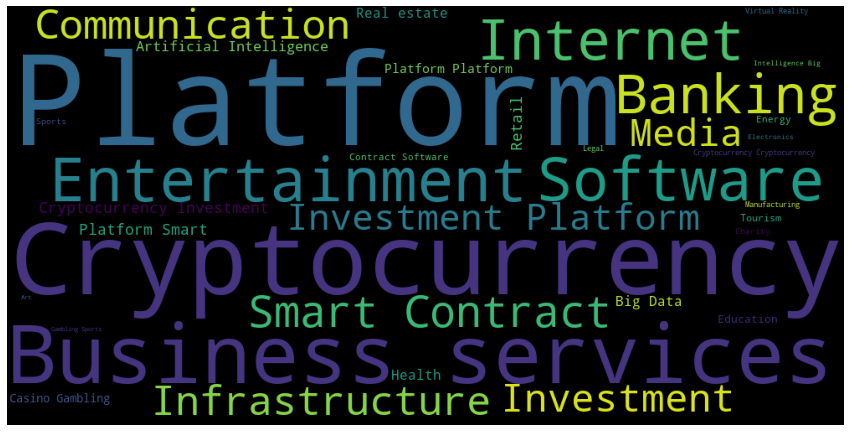

In [23]:
cat_list=[]
for lst in data['categories']:
    for cat in lst.split(","):
        cat_list.append(cat)
        
unique_string=(" ").join(cat_list)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

# Encoding

In [24]:
label_encoder = preprocessing.LabelEncoder()
data['country'] = label_encoder.fit_transform(data['country'])
data['platform'] = label_encoder.fit_transform(data['platform'])
data['acceptingCurrency'] = label_encoder.fit_transform(data['acceptingCurrency'])
data['tokenType'] = label_encoder.fit_transform(data['tokenType'])

In [25]:
df = data['categories'].str.split(',', expand=True).stack().reset_index(level=0).set_index('level_0').rename(columns={0:'categories'}).join(data.drop('categories', axis=1))
df = pd.get_dummies(df, columns = ['categories'], prefix = "cat")
df = df.groupby(['id']).max()

In [26]:
s = df.corr(method = 'pearson').iloc[0]
s.sort_values(axis=0, ascending=False)

success                        1.000000
overallrating                  0.523998
teamSize                       0.364614
video                          0.315480
socialMedia                    0.300551
tokenNum                       0.156290
hardcap                        0.140766
whitepaper                     0.111689
cat_Banking                    0.099863
cat_Big Data                   0.072819
cat_Platform                   0.065975
cat_Electronics                0.061558
softcap                        0.059839
cat_Internet                   0.049533
cat_Tourism                    0.046507
cat_Investment                 0.040177
cat_Casino & Gambling          0.040174
TokenPrice                     0.038589
cat_Sports                     0.030907
cat_Communication              0.029313
cat_Smart Contract             0.018855
cat_Business services          0.016184
cat_Media                      0.014902
cat_Entertainment              0.014002
cat_Retail                     0.004147


# Splitting the data

In [27]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

# Metrics

In [28]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,precision_score,recall_score,plot_roc_curve

def metric_print(y_test,y_pred, x_test, clf):
    print('Accuracy: ', accuracy_score(y_test,y_pred))
    print('Precision: ', precision_score(y_test,y_pred))
    print('Recall: ', recall_score(y_test,y_pred))
    print('F1 score: ', f1_score(y_test,y_pred)) 
    print('Confusion Matrix: \n', confusion_matrix(y_test,y_pred))
    plot_roc_curve(clf, x_test, y_test)
    plt.show() 

# SVM

## Finding best hyperparameters

In [29]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid']} 
  
CV_svm = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
CV_svm.fit(X_train, y_train)

# print best parameter after tuning
print(CV_svm.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] gamma=1, kernel=rbf .............................................
[CV] ................. gamma=1, kernel=rbf, score=0.551, total=   0.1s
[CV] gamma=1, kernel=rbf .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. gamma=1, kernel=rbf, score=0.551, total=   0.2s
[CV] gamma=1, kernel=rbf .............................................
[CV] ................. gamma=1, kernel=rbf, score=0.545, total=   0.2s

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s



[CV] gamma=1, kernel=rbf .............................................
[CV] ................. gamma=1, kernel=rbf, score=0.545, total=   0.2s
[CV] gamma=1, kernel=rbf .............................................
[CV] ................. gamma=1, kernel=rbf, score=0.549, total=   0.1s
[CV] gamma=1, kernel=sigmoid .........................................
[CV] ............. gamma=1, kernel=sigmoid, score=0.551, total=   0.1s
[CV] gamma=1, kernel=sigmoid .........................................
[CV] ............. gamma=1, kernel=sigmoid, score=0.551, total=   0.1s
[CV] gamma=1, kernel=sigmoid .........................................
[CV] ............. gamma=1, kernel=sigmoid, score=0.545, total=   0.1s
[CV] gamma=1, kernel=sigmoid .........................................
[CV] ............. gamma=1, kernel=sigmoid, score=0.545, total=   0.1s
[CV] gamma=1, kernel=sigmoid .........................................
[CV] ............. gamma=1, kernel=sigmoid, score=0.549, total=   0.1s
[CV] 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.6s finished


{'gamma': 0.0001, 'kernel': 'rbf'}


## Fitting the model

Accuracy:  0.6545454545454545
Precision:  0.6178343949044586
Recall:  0.8584070796460177
F1 score:  0.7185185185185184
Confusion Matrix: 
 [[47 60]
 [16 97]]


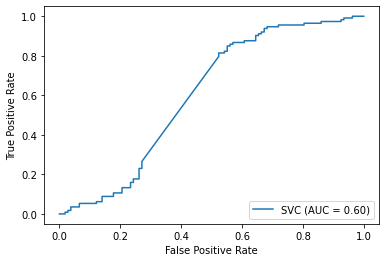

In [30]:
#Create a svm Classifier
svmc = SVC(kernel='rbf', gamma=0.0001, C=1)

#Train the model using the training sets
svmc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svmc.predict(X_test)

metric_print(y_test, y_pred, X_test, svmc)



# Random Forest

## Finding best hyperparameters

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

param_grid = { 
    'n_estimators': [100,200,500],
    'max_features': ['auto','sqrt', 'log2']
}

CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid)
CV_rf.fit(X, y)
print(CV_rf.best_params_)

{'max_features': 'sqrt', 'n_estimators': 100}


## Fitting the model

Accuracy:  0.8681818181818182
Precision:  0.868421052631579
Recall:  0.8761061946902655
F1 score:  0.8722466960352423
Confusion Matrix: 
 [[92 15]
 [14 99]]


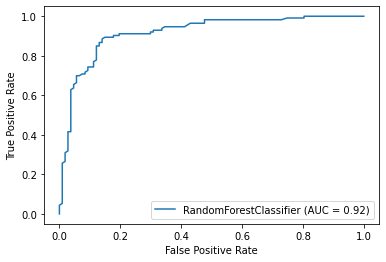

In [32]:

rf = RandomForestClassifier(max_features='auto', n_estimators=500)
# fit the model
rf.fit(X_train, y_train)
# predict model
y_pred=rf.predict(X_test)

metric_print(y_test, y_pred, X_test, rf)

# Naive Bayes

Accuracy:  0.6772727272727272
Precision:  0.8888888888888888
Recall:  0.4247787610619469
F1 score:  0.5748502994011976
Confusion Matrix: 
 [[101   6]
 [ 65  48]]


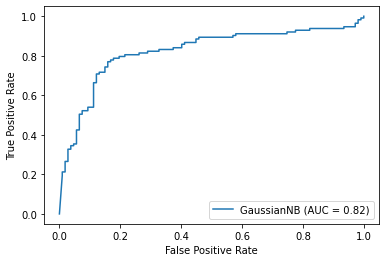

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test) 

metric_print(y_test, y_pred, X_test, nb)

# KNN Classifier

## Finding best hyperparameters

Minimum error:- 0.21363636363636362 at K = 64


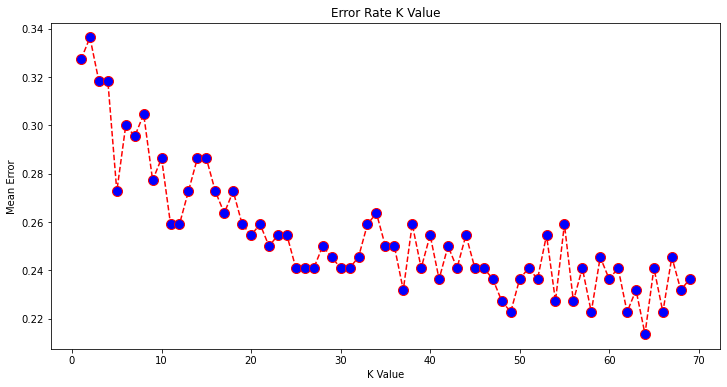

In [34]:
from sklearn.neighbors import KNeighborsClassifier  
error = []
# Calculating error for K values between 1 and 30
for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 100), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
print("Minimum error:-",min(error),"at K =",error.index(min(error))+1)

## Fitting the model

Accuracy:  0.7772727272727272
Precision:  0.7758620689655172
Recall:  0.7964601769911505
F1 score:  0.7860262008733625
Confusion Matrix: 
 [[81 26]
 [23 90]]


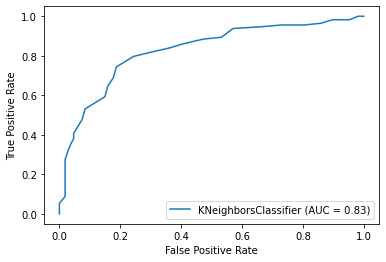

In [35]:
knn= KNeighborsClassifier(n_neighbors=62)  
knn.fit(X_train, y_train)
y_pred= knn.predict(X_test) 
metric_print(y_test, y_pred, X_test, knn)